<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# German News Articles

by Joel Akeret and Fabian Märki

## Summary
This is a short intro on how to access the *Ten Thousand German News Articles Dataset* for the *default project* (we still encourage you to work with your own dataset).

## Links
- [Ten Thousand German News Articles Dataset](https://tblock.github.io/10kGNAD/)

<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/XX_German_News_Article.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [16]:
#%%capture

#!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe

import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


We recommend to use the stratified train/test split proposed by the maintainer of the dataset.

In [17]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)

Get a first impression...

In [18]:
print(data_train.shape)
print(data_test.shape)

(9245, 2)
(1028, 2)


In [19]:
data_train["split"] = "train"
data_test["split"] = "test"

In [20]:
data_train.head(3)

,text_original,label,split
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train


In [21]:
data_test.head(3)

,text_original,label,split
0,"Die Gewerkschaft GPA-djp lanciert den ""All-in-Rechner"" und findet, dass die Vertragsform auf die Führungsebene beschränkt gehört. Wien – Die Gewerkschaft GPA-djp sieht Handlungsbedarf bei sogenannten All-in-Verträgen. Für mehr Transparenz haben die Gewerkschaft nun unter www.allinrechner.at ein Online-Werkzeug lanciert, das Arbeitnehmern mit solchen Verträgen helfen soll, sich einen Überblick zu verschaffen. Es geht darum, ob die Differenz zum Grundgehalt nicht womöglich eine zu geringe ist. Schließlich sei ein All-in-Gehalt oft nur auf den ersten Blick von Vorteil, gab GPA-djp-Chef Wolfga...",Wirtschaft,test
1,"Franzosen verteidigen 2:1-Führung – Kritische Stimmen zu Schwedens Superstar, Tore in K.-o.-Phase fehlen – Benfica mit Abwehrsorgen nach St. Petersburg. London – Mit einem trügerischen Vorsprung im Gepäck ist Paris Saint Germain zum Champions-League-Achtelfinale nach London gereist. Am Mittwochabend (20.45 Uhr) verteidigt Frankreichs Serienmeister gegen Chelsea ein 2:1 aus dem Hinspiel. PSG sollte gewarnt sein, die Blues sind seit der Trennung von Jose Mourinho erstarkt. Seit Dezember hat Chelsea unter Guus Hiddink in 18 Pflichtspielen nur die eine Niederlage in Paris einstecken müssen. Ei...",Sport,test
2,"Neues Video von Designern macht im Netz die Runde – sie schlagen etwa bunte Benachrichtigungen vor. Bei den iPhone-Verkaufszahlen ist der Wurm drin: Erstmals seit dessen Einführung musste Apple heuer sinkende Quartalsergebnisse bekanntgeben. CEO Tim Cook hat daher versprochen, das im Herbst erscheinende iPhone 7 werde Dinge können, die viele Menschen zu einer Kaufentscheidungen bewegen wird. Ein großer Bestandteil davon ist nicht nur die Hardware, sondern auch das Betriebssystem iOS. Dessen neueste Versionsnummer 10 könnte im Juni bei Apples WWDC-Event präsentiert werden. Noch ist nur weni...",Web,test


In [22]:
data_all = pd.concat([data_train, data_test])
data = data_train

In [23]:
data.head(3)

,text_original,label,split
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train


10273


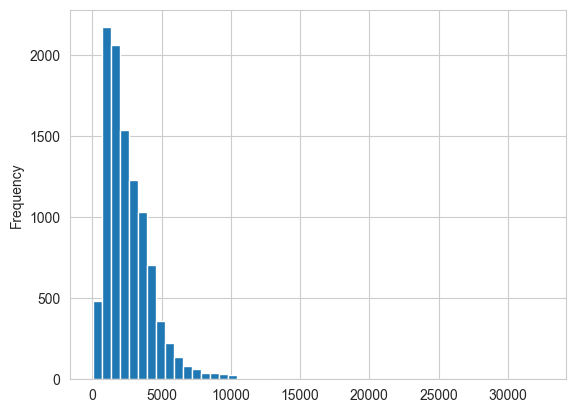

In [24]:
data_all['text_original'].str.len().plot(kind = 'hist', bins = 50)
print(len(data_all))

<Axes: xlabel='label'>

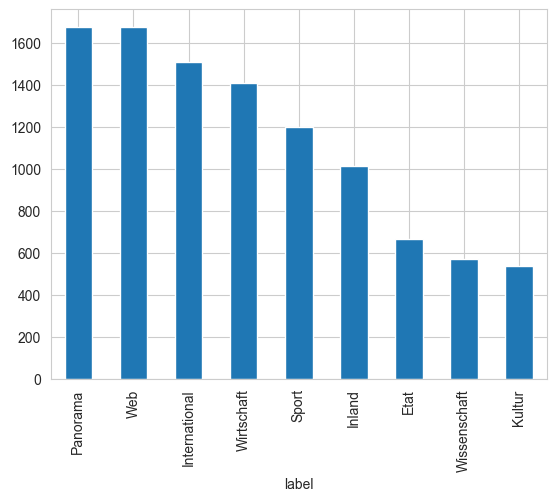

In [25]:
data_all['label'].value_counts().plot(kind = 'bar')

https://www.kaggle.com/datasets/tblock/10kgnad/code

In [26]:
for col in data_all.columns:
    print(f"Missing data for column [{col}]: {data_all[col].isnull().sum()}")

Missing data for column [text_original]: 0
Missing data for column [label]: 0
Missing data for column [split]: 0


In [27]:
df_all = data_all["label"].value_counts().sort_index()
df_train = data_train["label"].value_counts().sort_index()
df_test = data_test["label"].value_counts().sort_index()
df = pd.concat([df_all.to_frame(), df_train.to_frame(), df_test.to_frame()], axis=1)#, keys=["all","train","test"])
df.columns=["all","train","test"]
print (df)

                all  train  test
label                           
Etat            668    601    67
Inland         1015    913   102
International  1511   1360   151
Kultur          539    485    54
Panorama       1678   1510   168
Sport          1201   1081   120
Web            1677   1509   168
Wirtschaft     1411   1270   141
Wissenschaft    573    516    57


In [28]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""

    import re

    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [29]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

# Apply text cleaning using MODIN pandas dataframe (parallelized)
data_all["text"] =  data_all["text_original"].apply(clean_text, keep_punctuation = True)

In [30]:
data_all.head(3)

,text_original,label,split,text
0,"21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport,train,"Jähriger fällt wohl bis Saisonende aus. Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor."
1,"Erfundene Bilder zu Filmen, die als verloren gelten: ""The Forbidden Room"" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney ...",Kultur,train,"Erfundene Bilder zu Filmen, die als verloren gelten The Forbidden Room von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two Reeler von , den der arbeitswütige US Regisseur Allan Dwan. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein p..."
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt: Die Wutausbrüche von Apple-Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google-Mitgrü...",Web,train,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt Die Wutausbrüche von Apple Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google Mitgrün..."


In [31]:
data_all.loc[:,['text','label']]

,text,label
0,"Jähriger fällt wohl bis Saisonende aus. Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport
1,"Erfundene Bilder zu Filmen, die als verloren gelten The Forbidden Room von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two Reeler von , den der arbeitswütige US Regisseur Allan Dwan. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein p...",Kultur
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt Die Wutausbrüche von Apple Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google Mitgrün...",Web
3,"Putin Einigung, dass wir Menge auf Niveau von Jänner halten . Moskau Die russischen Ölproduzenten wollen nach den Worten von Präsident Wladimir Putin ihre Förderung in diesem Jahr einfrieren. Im Gro en und Ganzen wurde eine Einigung erzielt, dass wir die Ölproduktion auf dem Niveau von Jänner halten werden, sagte Putin am Mittwoch in Moskau. Russland leidet wie andere Förderstaaten unter dem drastischen Einbruch der Ölpreise. Putin will die Preise durch eine begrenzte Förderung im In und Ausland stabilisieren. Dazu hatte Russland jüngst mit Saudi Arabien und anderen gro en Förderländern üb...",Wirtschaft
4,"Estland sieht den künftigen österreichischen Präsidenten auch als estnischen Staatsbürger. Wien Tallinn Pskow Die Eltern des künftigen Bundespräsidenten waren aus dem von Sowjets besetzten Estland in das damalige Deutsche Reich geflohen, wo in Wien Sascha Van der Bellen zur Welt kam. Estnische Verwandte jubelten am Dienstag über dessen Wahlsieg, Freude herrscht auch unter Politikern des Landes. Interesse an Van der Bellen gibt es auch in der russischen Stadt Pskow, der Geburtsstadt seiner Eltern. Wir haben von ganzem Herzen und mit der ganzen Familie mitgefiebert, sagt Irina Steinberg, ein...",Inland
...,...,...
1023,"Programm Ebay Plus soll Ende September starten, aber nur in Deutschland Rückgabemöglichkeit entscheidender Faktor für Onlinekäufer . Bei Ebay können Käufer in Deutschland künftig gegen eine Jahresgebühr auf Portokosten für Rücksendungen verzichten. Wer das Programm Ebay Plus für , Euro im Jahr bucht, bekommt seine Bestellung am nächsten oder spätestens übernächsten Tag und kann die Ware einen Monat lang kostenlos zurücksenden, wie das Unternehmen am Freitag mitteilte. Die Ebay Plus Kunden erhielten zudem Zugang zu exklusiven Deals. Das Programm solle Ende September schrittweise eingeführt ...",Web
1024,"Fehlerhafte Bilanz , Partei will berufen Keine Strafe wegen Wahlkampffinanzierung durch Parlamentsklub. Wien Das BZÖ ist als erste Partei zu einer Geldbu wegen eines unrichtigen Rechenschaftsberichtes verurteilt worden. Weil in der Bilanz für das Jahr keine Angaben zur niederösterreichischen Landespartei gemacht wurden, verhängte der Unabhängige Parteien Transparenz Senat UPTS im Kanzleramt . Euro Strafe. Die Partei will berufen und fehlende Unterlagen nachliefer

In [32]:

from transformers import AutoTokenizer, TFAutoModel
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")


(…)base-german-cased/resolve/main/vocab.txt: 100%|██████████| 255k/255k [00:00<00:00, 24.8MB/s]
c:\Users\reto.steiner\Desktop\NLP\.venv\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\reto.steiner\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
(…)cased/resolve/main/tokenizer

In [33]:

MAXLEN = 192

def tokenize(data_all):
    encoded = tokenizer.encode_plus(
        text= data_all,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=MAXLEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )

    return encoded['input_ids']


In [34]:
data_train = data_all[data_all['split'] == 'train'].loc[:,['text','label']]
data_train.head()

,text,label
0,"Jähriger fällt wohl bis Saisonende aus. Wien Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene Jährige erlitt beim Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden. Dennoch steht ihm eine mehrwöchige Pause bevor.",Sport
1,"Erfundene Bilder zu Filmen, die als verloren gelten The Forbidden Room von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two Reeler von , den der arbeitswütige US Regisseur Allan Dwan. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein p...",Kultur
2,"Der frischgekürte CEO Sundar Pichai setzt auf ein umgänglicheres Führungsteam. Die Atmosphäre im Silicon Valley ist rau. Da werden massenhaft Mitarbeiter der direkten Konkurrenz abgeworben, Löhne mit firmenübergreifenden Mauscheleien niedrig gehalten und Untergebene wegen leicht verfehlter Ziele vor die Tür gesetzt. Auch in der höchsten Firmenebene werden brutale Umgangsformen gepflegt Die Wutausbrüche von Apple Mitgründer Steve Jobs sind legendär, sein früherer Geschäftspartner Steve Wozniak hätte ihn zu Lebzeiten gerne als Arschloch beschimpft, traute sich aber nicht. Auch Google Mitgrün...",Web
3,"Putin Einigung, dass wir Menge auf Niveau von Jänner halten . Moskau Die russischen Ölproduzenten wollen nach den Worten von Präsident Wladimir Putin ihre Förderung in diesem Jahr einfrieren. Im Gro en und Ganzen wurde eine Einigung erzielt, dass wir die Ölproduktion auf dem Niveau von Jänner halten werden, sagte Putin am Mittwoch in Moskau. Russland leidet wie andere Förderstaaten unter dem drastischen Einbruch der Ölpreise. Putin will die Preise durch eine begrenzte Förderung im In und Ausland stabilisieren. Dazu hatte Russland jüngst mit Saudi Arabien und anderen gro en Förderländern üb...",Wirtschaft
4,"Estland sieht den künftigen österreichischen Präsidenten auch als estnischen Staatsbürger. Wien Tallinn Pskow Die Eltern des künftigen Bundespräsidenten waren aus dem von Sowjets besetzten Estland in das damalige Deutsche Reich geflohen, wo in Wien Sascha Van der Bellen zur Welt kam. Estnische Verwandte jubelten am Dienstag über dessen Wahlsieg, Freude herrscht auch unter Politikern des Landes. Interesse an Van der Bellen gibt es auch in der russischen Stadt Pskow, der Geburtsstadt seiner Eltern. Wir haben von ganzem Herzen und mit der ganzen Familie mitgefiebert, sagt Irina Steinberg, ein...",Inland


In [35]:
data_test = data_all[data_all['split'] == 'test'].loc[:,['text','label']]
data_test.head()

,text,label
0,"Die Gewerkschaft GPA djp lanciert den All in Rechner und findet, dass die Vertragsform auf die Führungsebene beschränkt gehört. Wien Die Gewerkschaft GPA djp sieht Handlungsbedarf bei sogenannten All in Verträgen. Für mehr Transparenz haben die Gewerkschaft nun unter www allinrechner at ein Online Werkzeug lanciert, das Arbeitnehmern mit solchen Verträgen helfen soll, sich einen Überblick zu verschaffen. Es geht darum, ob die Differenz zum Grundgehalt nicht womöglich eine zu geringe ist. Schlie lich sei ein All in Gehalt oft nur auf den ersten Blick von Vorteil, gab GPA djp Chef Wolfgang K...",Wirtschaft
1,"Franzosen verteidigen Führung Kritische Stimmen zu Schwedens Superstar, Tore in. Phase fehlen Benfica mit Abwehrsorgen nach St. Petersburg. London Mit einem trügerischen Vorsprung im Gepäck ist Paris Saint Germain zum Champions League Achtelfinale nach London gereist. Am Mittwochabend . Uhr verteidigt Frankreichs Serienmeister gegen Chelsea ein aus dem Hinspiel. PSG sollte gewarnt sein, die Blues sind seit der Trennung von Jose Mourinho erstarkt. Seit Dezember hat Chelsea unter Guus Hiddink in Pflichtspielen nur die eine Niederlage in Paris einstecken müssen. Ein würde den Hausherren reich...",Sport
2,"Neues Video von Designern macht im Netz die Runde sie schlagen etwa bunte Benachrichtigungen vor. Bei den iPhone Verkaufszahlen ist der Wurm drin Erstmals seit dessen Einführung musste Apple heuer sinkende Quartalsergebnisse bekanntgeben. CEO Tim Cook hat daher versprochen, das im Herbst erscheinende iPhone werde Dinge können, die viele Menschen zu einer Kaufentscheidungen bewegen wird. Ein gro er Bestandteil davon ist nicht nur die Hardware, sondern auch das Betriebssystem iOS. Dessen neueste Versionsnummer könnte im Juni bei Apples WWDC Event präsentiert werden. Noch ist nur wenig über n...",Web
3,"jähriger Brasilianer muss vier Spiele pausieren Entscheidung kann noch angefochten werden Chile und Bolivien im Viertelfinale, Mexiko out. Santiago de Chile Wegen seiner Provokation nach dem Spiel gegen Kolumbien hat der südamerikanische Fu ballverband CONMEBOL Brasiliens Top Stürmer Neymar für vier Spiele gesperrt. Zudem verhängte der Disziplinarausschuss eine Geldstrafe in Höhe von . US Dollar. Euro gegen den Jährigen. Damit dürfte Neymar bei der laufenden Regionalmeisterschaft Copa America in Chile nicht mehr zum Einsatz kommen. Die Entscheidung kann noch angefochten werden. Beim Vorru...",Sport
4,"Aufständische verwendeten Chemikalie bei Gefechten im August. Damaskus Bei Kämpfen zwischen Rebellengruppen in Syrien ist nach Angaben unabhängiger Experten Senfgas eingesetzt worden. Die Chemikalie sei am . August bei Gefechten in Marea in der nördlichen Provinz Aleppo verwendet worden, verlautete am Donnerstag aus Kreisen der Organisation für das Verbot von Chemiewaffen OPCW . Es handelt sich demnach um den ersten bestätigten Einsatz von Senfgas in dem Bürgerkriegsland. Der UN Sicherheitsrat hatte Anfang August beschlossen, dass ein Team aus Experten der Vereinten Nationen sowie der OPCW...",International


In [36]:
input_ids_train = np.array([tokenize(data_train) for data_train in tqdm.tqdm(data_train['text'])])
input_ids_test = np.array([tokenize(data_test) for data_test in tqdm.tqdm(data_test['text'])])

100%|██████████| 1028/1028 [00:08<00:00, 122.13it/s]


In [37]:

label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
print(f"Classes: {label_binarizer.classes_}")
print (f"Encoding:\n {label_binarizer.transform(label_binarizer.classes_).T}")

Classes: ['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
Encoding:
 [[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


In [38]:
train_ids, test_ids, train_labels, test_labels = input_ids_train, input_ids_test, label_binarizer.transform(data_train['label']),label_binarizer.transform(data_test['label'])

In [39]:
#train_labels.drop_duplicates()

In [40]:
BATCH_SIZE = 16
EPOCHS = 8
LEARNING_RATE = 1e-5

In [54]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_ids, train_labels))
                    .shuffle(buffer_size=len(train_ids), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))

test_dataset = (tf.data.Dataset.from_tensor_slices((test_ids, test_labels))
                    .batch(BATCH_SIZE))


In [42]:
NUM_CLASSES = len(pd.DataFrame(train_labels).drop_duplicates())
NUM_CLASSES

9

In [49]:
def build_model(max_len=MAXLEN): #                dropout_rate=0.2):
    """ add multiclass classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased")
    encoder_outputs = bert_model(input_word_ids)

    ##########################
    ## YOUR CODE HERE START ##
    ##########################

    # Either use last_hidden_state use pooler_output
    # that were returned in encoder_outputs
    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]

    # In this case we will use the cls_embedding
    cls_embedding = pooler_output
    # Adding a Dropout layer
    #dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)(cls_embedding)

    # Create a feed-forward neural network with one hidden layer
    hidden = tf.keras.layers.Dense(128, activation='relu')(cls_embedding)
    # Change the output dimension to match the number of classes
    output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden)

    ##########################
    ## YOUR CODE HERE END ##
    ##########################

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)

    return model


In [50]:
model = build_model(max_len=MAXLEN)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 192)]             0         
 )                                                               
                                                                 
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPo   109081344 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 192, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                 

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = loss="categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy"], jit_compile=True)

In [56]:
from datetime import datetime  # Stellen Sie sicher, dass Sie datetime importiert haben

# Ändern Sie den Log-Pfad
log_dir = 'logs/' + datetime.now().strftime("%Y%m%d_%H%M%S")

hist = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_dataset,
    steps_per_epoch=int(np.floor((len(input_ids_train) / BATCH_SIZE))),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="accuracy", verbose=1, patience=1, restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir)  # Verwenden Sie den geänderten Log-Pfad
    ],
)

Epoch 1/8
577/577 [==============================] - 8061s 14s/step - loss: 0.6522 - accuracy: 0.7963 - val_loss: 0.3523 - val_accuracy: 0.8833
Epoch 2/8
577/577 [==============================] - 7808s 14s/step - loss: 0.2684 - accuracy: 0.9123 - val_loss: 0.3188 - val_accuracy: 0.9027
Epoch 3/8
577/577 [==============================] - 7797s 14s/step - loss: 0.1506 - accuracy: 0.9529 - val_loss: 0.3403 - val_accuracy: 0.8979
Epoch 4/8
577/577 [==============================] - 7845s 14s/step - loss: 0.0832 - accuracy: 0.9749 - val_loss: 0.3680 - val_accuracy: 0.9047
Epoch 5/8
577/577 [==============================] - 7806s 14s/step - loss: 0.0454 - accuracy: 0.9879 - val_loss: 0.4565 - val_accuracy: 0.8988
Epoch 6/8
577/577 [==============================] - 7813s 14s/step - loss: 0.0360 - accuracy: 0.9899 - val_loss: 0.4349 - val_accuracy: 0.9018
Epoch 7/8
577/577 [==============================] - 8895s 15s/step - loss: 0.0208 - accuracy: 0.9943 - val_loss: 0.5818 - val_accuracy:

In [60]:
"""
!pip install session-info
import session_info
session_info.show()
"""


'\n!pip install session-info\nimport session_info\nsession_info.show()\n'

In [61]:
history = pd.DataFrame({'epoch': hist.epoch, **hist.history}).set_index('epoch')
history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
0,0.652209,0.796252,0.352344,0.883268
1,0.268431,0.912262,0.318774,0.902724
2,0.150560,0.952881,0.340259,0.897860
3,0.083183,0.974870,0.367999,0.904669
4,0.045398,0.987868,0.456498,0.898833
5,0.035990,0.989926,0.434878,0.901751
6,0.020777,0.994259,0.581790,0.891051
7,0.019308,0.994584,0.517145,0.903696


	0.014772	0.995451	0.537464	0.899805 war vorher

<Axes: xlabel='epoch'>

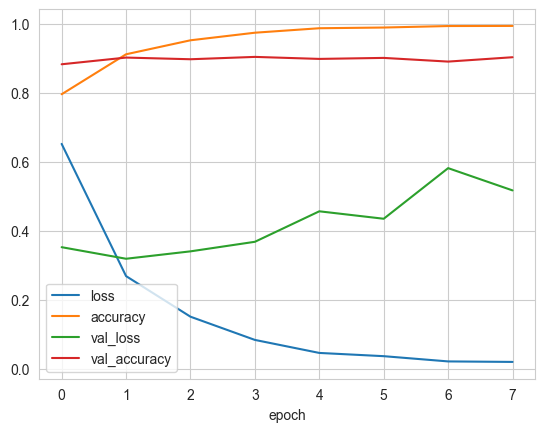

In [62]:
history.plot()

In [65]:
result = model.predict(test_ids)


33/33 [==============================] - 274s 8s/step


In [66]:
result = result > .5
y_pred = result.astype(int)
y_true = test_labels

In [67]:
l = list(label_binarizer.classes_)

In [68]:

conf = multilabel_confusion_matrix(y_true, y_pred)

conf

array([[[954,   7],
        [ 10,  57]],

       [[917,   9],
        [ 15,  87]],

       [[865,  12],
        [ 26, 125]],

       [[965,   9],
        [  5,  49]],

       [[831,  29],
        [ 25, 143]],

       [[907,   1],
        [  0, 120]],

       [[856,   4],
        [  5, 163]],

       [[863,  24],
        [  9, 132]],

       [[965,   6],
        [  8,  49]]], dtype=int64)